# Large Language Mario

LLMを使ってマリオをプレイするチャレンジ

## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [114]:
!pip install -qqq gym-super-mario-bros==7.3.0

その他、必要なライブラリをインストールします。

In [115]:
!apt -qq update
!apt install -y -qq xvfb
!pip install -qqq pyvirtualdisplay

50 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [116]:
# パッケージのインストール
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-rlfzosdf
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-rlfzosdf
  Resolved https://github.com/huggingface/transformers to commit eb5b968c5d80271ecb29917dffecc8f4c00247a8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


必要なライブラリをインポートします。

In [117]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
import requests

import os
from google.colab import userdata
import base64
import json

## AIマリオ環境の構築

AIマリオの環境構築を行います。



### AIマリオ環境初期化と動作確認
環境の確認です。

In [118]:
STAGE_NAME = 'SuperMarioBros-1-1-v0'

In [119]:
# マリオ1-1の環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定します。
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# MOVEMENT = [["right"], ["right", "A"]]
# env = JoypadSpace(env, MOVEMENT)
# env = JoypadSpace(env, COMPLEX_MOVEMENT)
# env = JoypadSpace(env, RIGHT_ONLY)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


ステージの初期化と行動空間の設定をしています。

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されています。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

自分で自由に設定する他、`gym_super_mario_bros`では`SIMPLE_MOVEMENT`, `COMPLEX_MOVEMENT`といった複数のパターンが登録されています。どのようなパターンがあるかは、[gym_super_mario_brosのソースコード](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py)を読むか、以下のように中身を`print`して確認する方法があります。

L今回は`SIMPLE_MOVEMENT`を採用しています。

In [120]:
print(SIMPLE_MOVEMENT)
print(COMPLEX_MOVEMENT)

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [121]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0.0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


行動`action`の範囲や状態`state`の範囲を確認したい場合は、以下を実行してください。

```python
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

print('action space------------------')
print_spaces(env.action_space)
print('observation space------------------')
print_spaces(env.observation_space)
```

最後に`state`を画像として可視化してみます。

マリオのプレイ画面であることを確認できます。

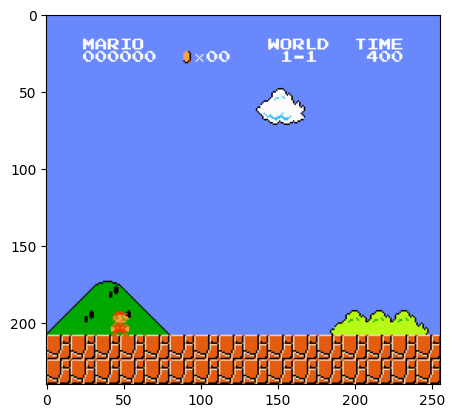

In [122]:
plt.imshow(state)

`state`は`numpy.ndarray'です。

In [123]:
print(type(state))

<class 'numpy.ndarray'>


`state`を画像に変換します。

In [124]:
image = Image.fromarray(state)
image.save('state.png')

画像も表示を確認します

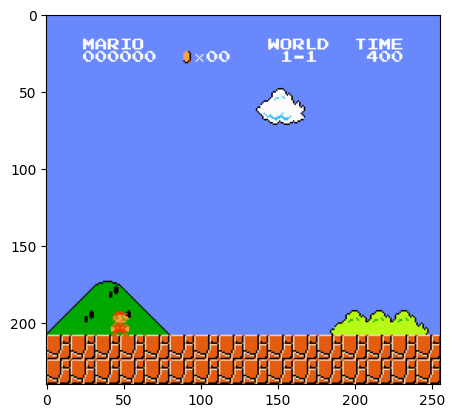

In [125]:
img = Image.open('state.png')
imshow(img)

## LLMのテスト

LLMが正しく画像を読み込んでプレイできるかテストします。
Qwen2_vl(2b)をセットアップします。

In [126]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

# モデルとプロセッサの準備
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct"
)

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1381: UserWarning: Current model requires 67109376 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LLMの準備をします。

In [127]:
from PIL import Image
import requests

# 画像の準備
image = img

# メッセージの準備
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "これはなんというゲーム？"},
        ],
    }
]

# 入力の準備
text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt"
)
inputs = inputs.to("cuda")

# 推論の実行
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
print(output_text)

['これは「スーパーマリオブラザーズ」のスクリーンショットです。これは1985年に発売された、任天堂が開発したアクション型のゲームソフトです。']


画像からマリオの動きを推論する関数を定義します。

In [147]:
import re

def extract_numbers(text):
    # 文字列から数値を抽出
    numbers = re.findall(r'\d+', text)

    # 数値が見つからなければNoneを返す
    if not numbers:
        return None

    # 数値を整数型に変換してリストで返す
    return [int(num) for num in numbers]

In [148]:
# [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
# 'NOOP' means no operation. 'A' means jump. 'B' means dash. 'left' means move left. 'right' means move right
#   You analyze the situation on the screen in the detail and investigate Mario to avoid enemies and reach the goal.

In [369]:
def predict(state, action=0):
  image = Image.fromarray(state)

  prompt = f"""You are the awesome game player of Super Mario.
  You have operated {SIMPLE_MOVEMENT[action]}. How will you operate Mario next?
  You analyze the situation on the screen shot in the detail and investigate Mario to avoid enemies and reach the goal.

  Please choose one of the seven button operations below and answer with the number.

  0 = 'NOOP' # No operation
  1 = 'right' # Move right
  2 = 'right', 'A' # Move right and jump
  3 = 'right', 'B' # Move right and dash
  4 = 'right', 'A', 'B' # Move right, jump, and dash
  5 = 'A' # Jump
  6 = 'left' # Move left

  Tips: For the jump start operation, select 1, 6, followed by the JUMP operation. If you don't jump, try.

  Please answer only the number.
  """

  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
              },
              {"type": "text", "text": prompt},
          ],
      }
  ]
  # 入力の準備
  text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
  inputs = processor(
      text=[text_prompt],
      images=[image],
      padding=True,
      return_tensors="pt"
  )
  inputs = inputs.to("cuda")

  # 推論の実行
  output_ids = model.generate(**inputs, max_new_tokens=128)
  generated_ids = [
      output_ids[len(input_ids) :]
      for input_ids, output_ids in zip(inputs.input_ids, output_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
  )

  result = extract_numbers(output_text[0])
  if result is None:
    return 0, "", ""
  action = result[0]

  return action, "", ""

推論する関数をテストします。

In [370]:
action, explanation, reason = predict(state, 0)

アクションを確認します。右に進む（`1`）かダッシュして右に進む（`2`）になっていることを確認します。

In [371]:
action

4

In [372]:
SIMPLE_MOVEMENT[action]

['right', 'A', 'B']

マリオの状況判断（画像の説明）を確認します。今回は簡単のためになしです。

In [373]:
explanation

''

行動の理由を確認します。これも今回は簡単のためになしです。

In [374]:
reason

''

## AIマリオのテスト

AIモデルをテストします。

テスト回数等を設定します。

In [375]:
EPISODE_NUMBERS = 1
MAX_TIMESTEP_TEST = 1000
SKIP_RATE = 1

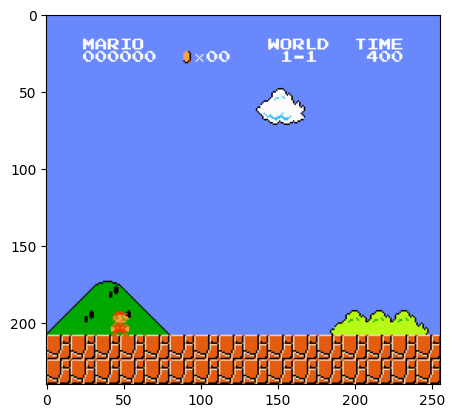

action: 4
explanation: 
reason: 


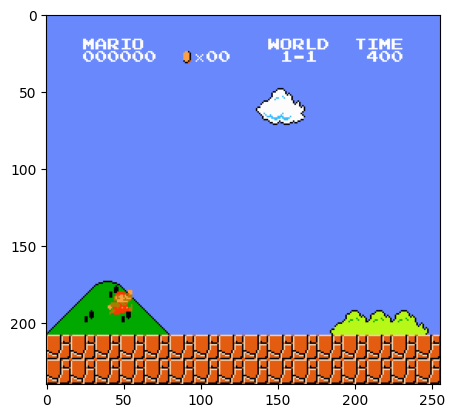

action: 4
explanation: 
reason: 


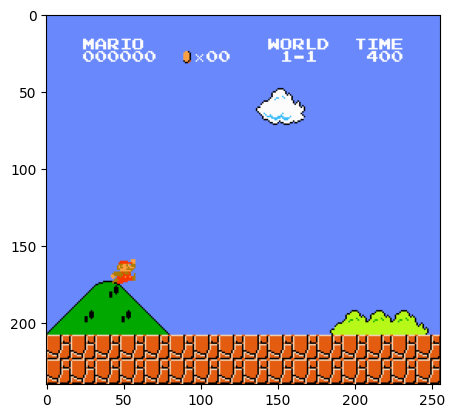

action: 4
explanation: 
reason: 


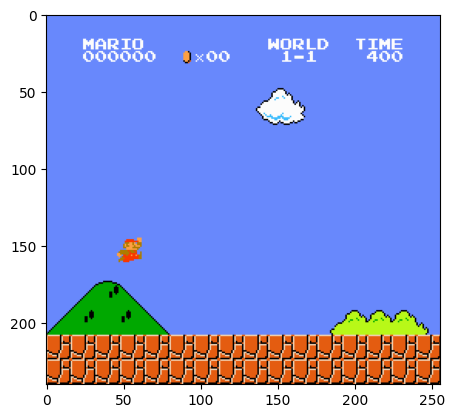

action: 4
explanation: 
reason: 


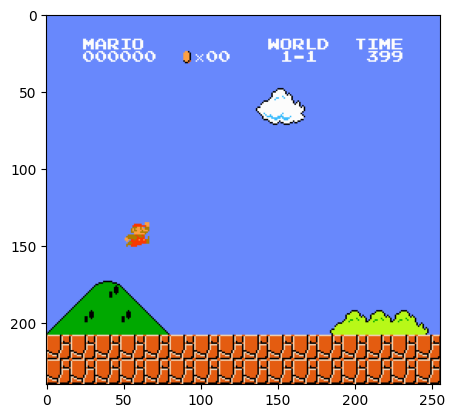

action: 4
explanation: 
reason: 


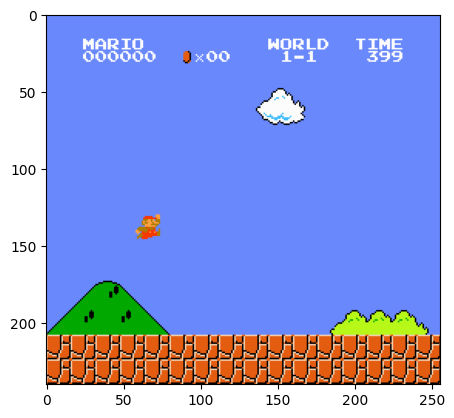

action: 4
explanation: 
reason: 


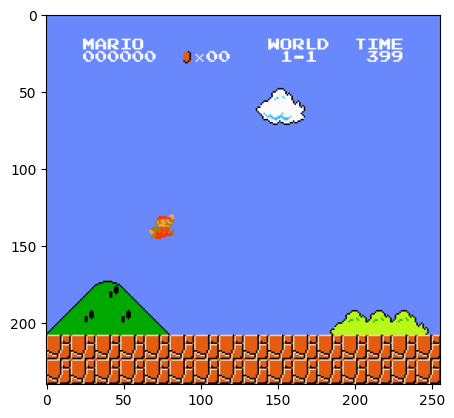

action: 4
explanation: 
reason: 


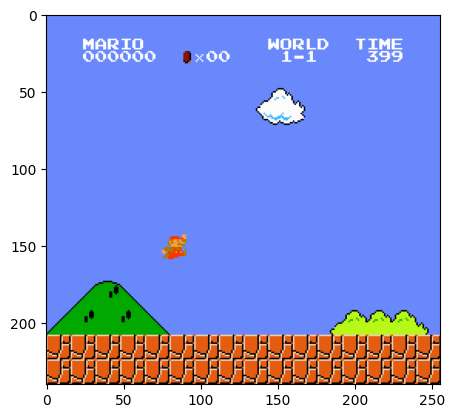

action: 4
explanation: 
reason: 


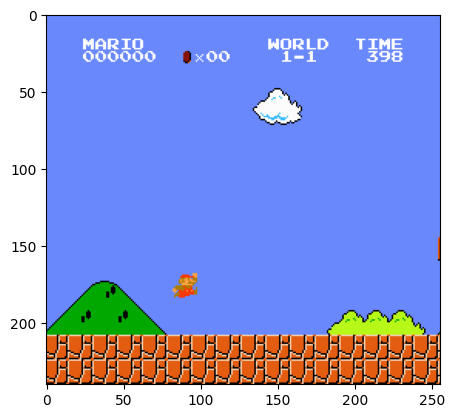

action: 4
explanation: 
reason: 


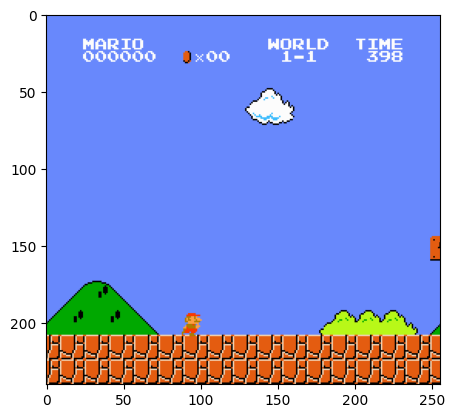

action: 4
explanation: 
reason: 


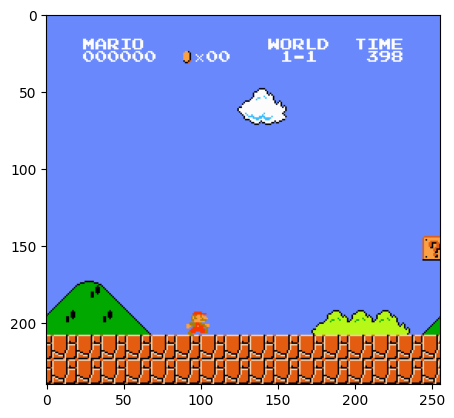

action: 4
explanation: 
reason: 


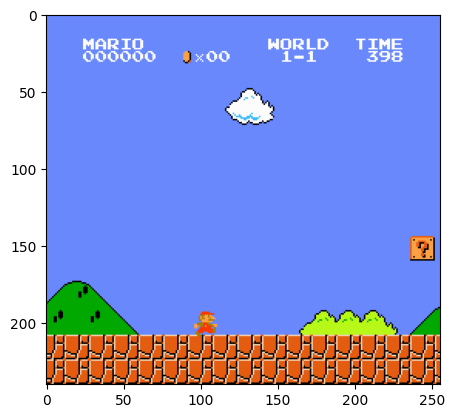

action: 4
explanation: 
reason: 


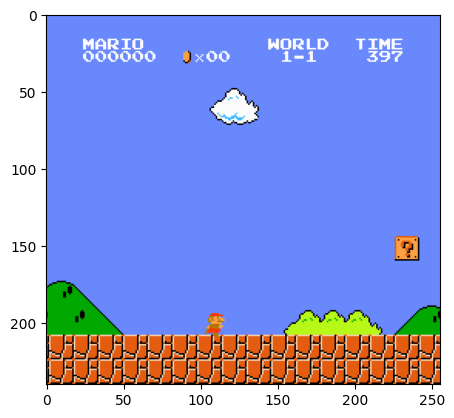

action: 4
explanation: 
reason: 


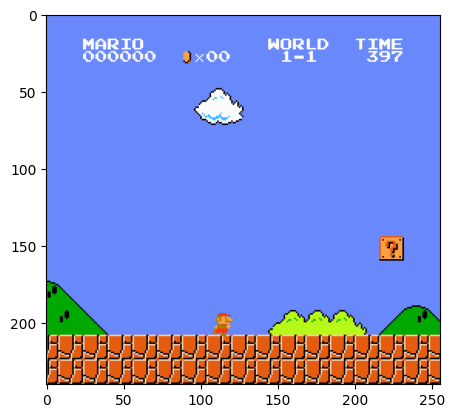

action: 4
explanation: 
reason: 


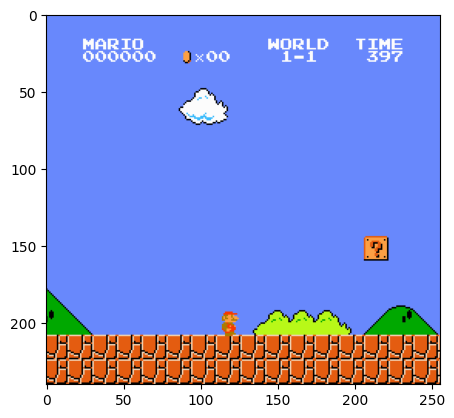

action: 4
explanation: 
reason: 


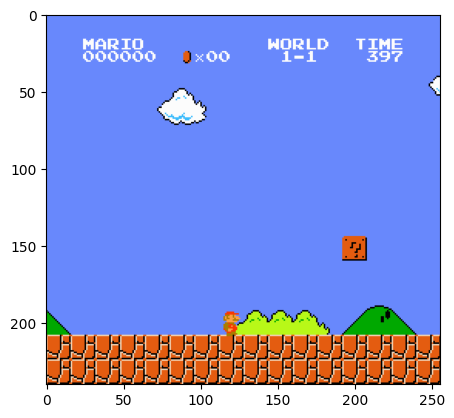

action: 4
explanation: 
reason: 


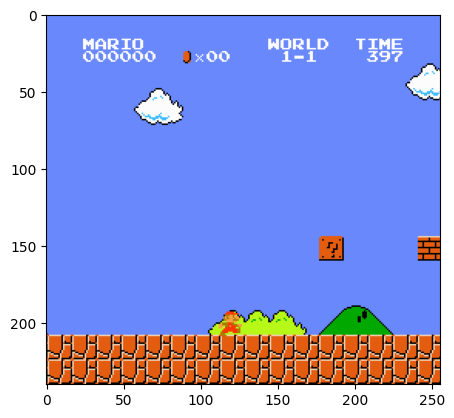

action: 4
explanation: 
reason: 


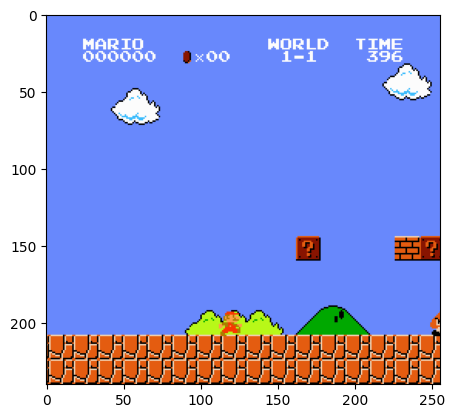

action: 4
explanation: 
reason: 


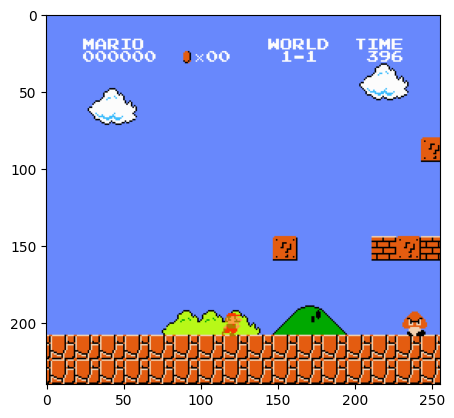

action: 4
explanation: 
reason: 


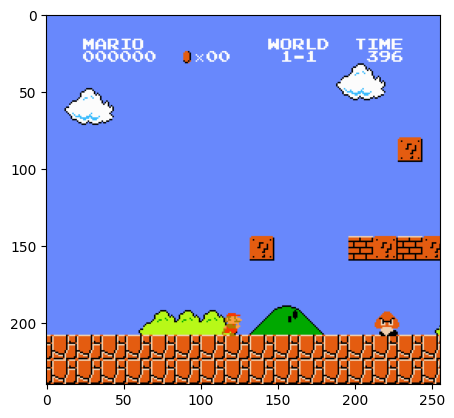

action: 4
explanation: 
reason: 


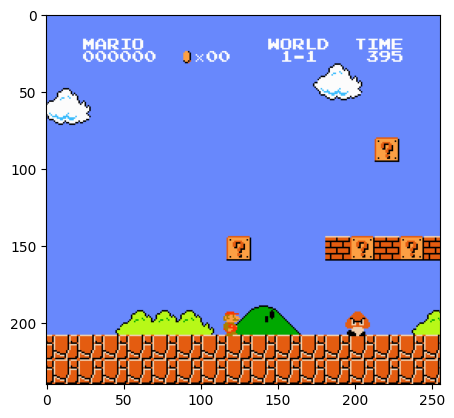

action: 4
explanation: 
reason: 


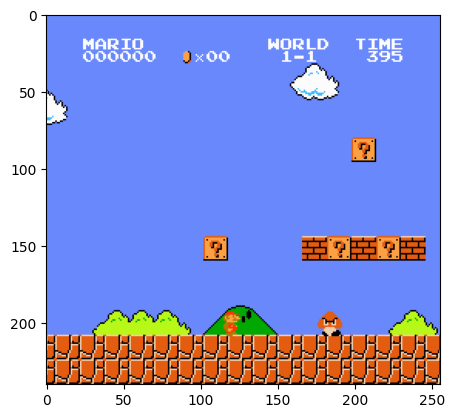

action: 4
explanation: 
reason: 


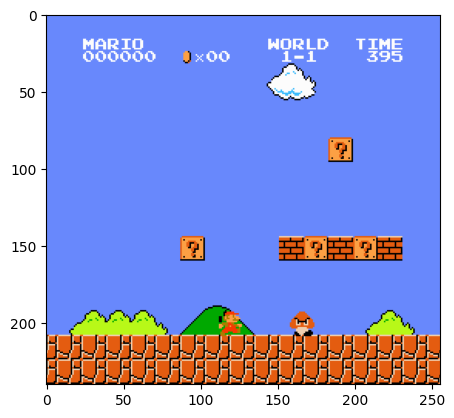

action: 4
explanation: 
reason: 


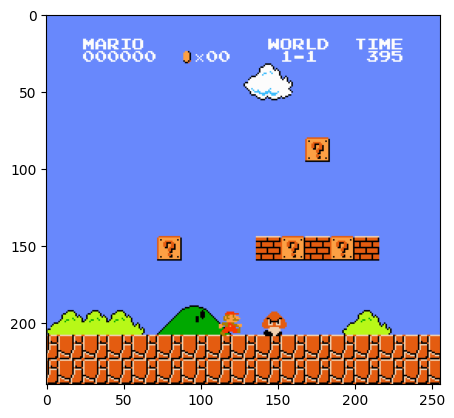

action: 4
explanation: 
reason: 
test episode: 0 reward: 250.0 time: 120
average reward: 250.0 average time: 120.0 best_reward: 250.0


In [387]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []
reason = ""
action = 3


for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0.0
    total_time[i] = 0
    skip_numb = SKIP_RATE
    frames = []
    action = 0

    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        if skip_numb < SKIP_RATE:
            skip_numb += 1
        else:
            skip_numb = 0
            action, explanation, reason = predict(state, action)

            plt.imshow(state)
            plt.pause(0.001)

            print(f'action: {action}')
            print(f'explanation: {explanation}')
            print(f'reason: {reason}')

        state, reward, done, info = env.step(action)
        total_reward[i] += reward
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

`<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>`という表示ができたらクリアできています。

クリアできない場合は、複数回プレイして一番良いプレイ動画が保存されます。

実行のたびに結果は変わります。何回か試してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [377]:
SKIP_RATE = 4

画像を間引く処理をします。

In [378]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

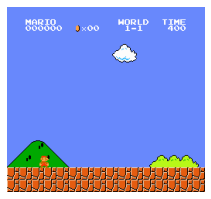

In [379]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。

In [380]:
ani.save('ai_mario.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


動画ファイルをダウンロードします。

In [381]:
from google.colab import files
files.download('ai_mario.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GIFアニメ形式で保存します。

In [382]:
import imageio
imageio.mimsave('ai_mario.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=15)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


GIFアニメをダウンロードします。

In [383]:
from google.colab import files
files.download('ai_mario.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## リファレンス

- https://platform.openai.com/docs/guides/vision
- https://platform.openai.com/docs/guides/structured-outputs/introduction
- https://openai.com/index/introducing-structured-outputs-in-the-api/
- https://qiita.com/DEmodoriGatsuO/items/4c4734b78973970e0d3d
- https://platform.openai.com/settings/organization/billing/overview

LLM
- https://note.com/npaka/n/n6e2a00a0c0e7